# Using deep learning to predict dissolved inorganic carbon (DIC) in water samples

## [Link to GitHub repository](https://github.com/linusghanadan/ml-kaggle-competition)

## Background

Using the online platform Kaggle, my machine learning class is having a competition to see who can create the best predictive model (goal is to build model with lowest MSE for testing data). Our task is to build a model that predicts **dissolved inorganic carbon (DIC)** content in water samples based on other ocean chemistry features that are also measured in the same sample. Our data set comes from the **California Cooperative Oceanic Fisheries Investigations (CalCOFI)**, an oceanographic and marine ecosystem research program located in California ([link to data set source](https://calcofi.org/data/oceanographic-data/bottle-database/)). All water samples were taken off the California coast.

## My approach

For this competition, I'll be experimenting with deep learning techniques that we have only briefly covered in the class. I'm skeptical that this approach will yield better results than a technique based on decision trees, but I'm curious to gain some experience building artificial neural networks and see how the tuning process compares to the other techniques we have practiced in class.

## Setup

In [10]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load ML libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import HyperModel, RandomSearch
from sklearn.model_selection import KFold
import itertools

# Set the environment variable to change the log level
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = default, 1 = no INFO, 2 = no INFO and WARNING, 3 = no INFO, WARNING, and ERROR

## Data import & basic pre-processing

In [5]:
# import training data
train_df = pd.read_csv('../../data/train.csv')
train_df.columns = train_df.columns.str.lower().str.replace(' ', '_') # clean column names

# inspect data
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454 entries, 0 to 1453
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1454 non-null   int64  
 1   lat_dec            1454 non-null   float64
 2   lon_dec            1454 non-null   float64
 3   no2um              1454 non-null   float64
 4   no3um              1454 non-null   float64
 5   nh3um              1454 non-null   float64
 6   r_temp             1454 non-null   float64
 7   r_depth            1454 non-null   int64  
 8   r_sal              1454 non-null   float64
 9   r_dynht            1454 non-null   float64
 10  r_nuts             1454 non-null   float64
 11  r_oxy_micromol.kg  1454 non-null   float64
 12  unnamed:_12        0 non-null      float64
 13  po4um              1454 non-null   float64
 14  sio3um             1454 non-null   float64
 15  ta1.x              1454 non-null   float64
 16  salinity1          1454 

In [6]:
# remove 'id' and 'unnamed:_12' columns
train_df = train_df.drop(train_df.columns[[0, 12]], axis=1)

## Data exploration & additional pre-processing

<Figure size 1200x1000 with 0 Axes>

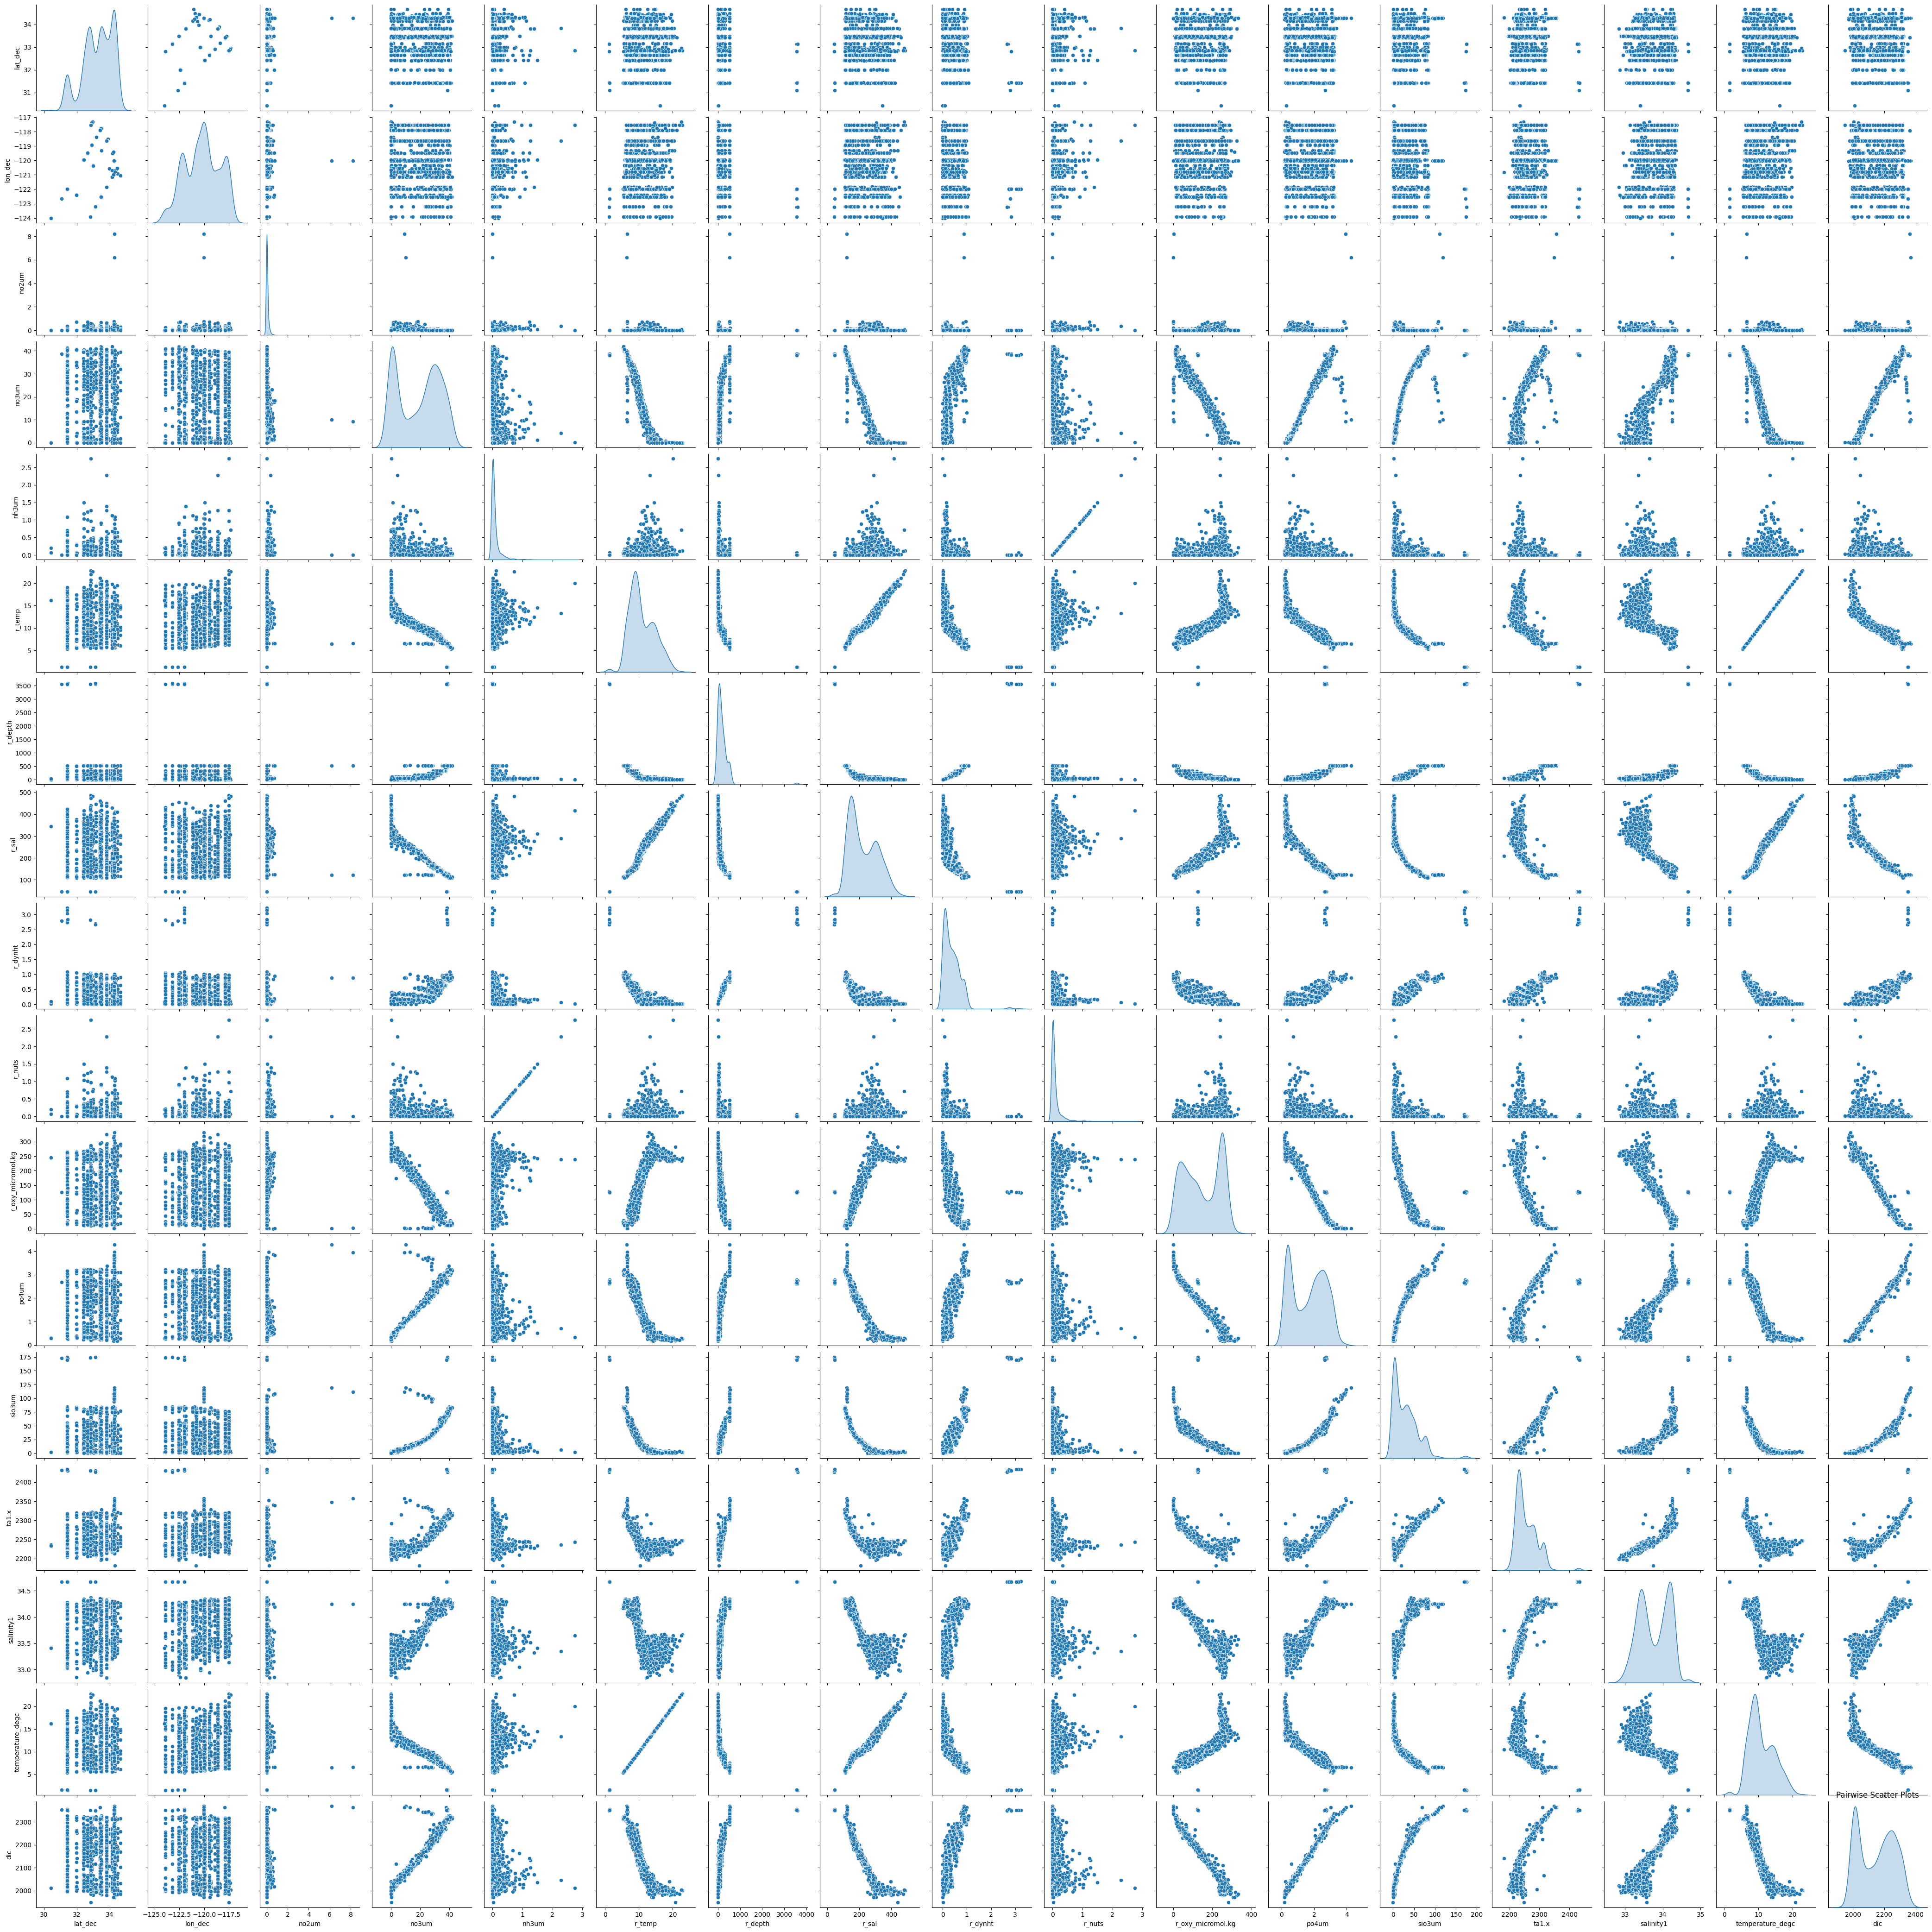

In [13]:
plt.figure(figsize=(12, 10))
sns.pairplot(train_df, diag_kind='kde')
plt.title('Pairwise Scatter Plots')
plt.show()

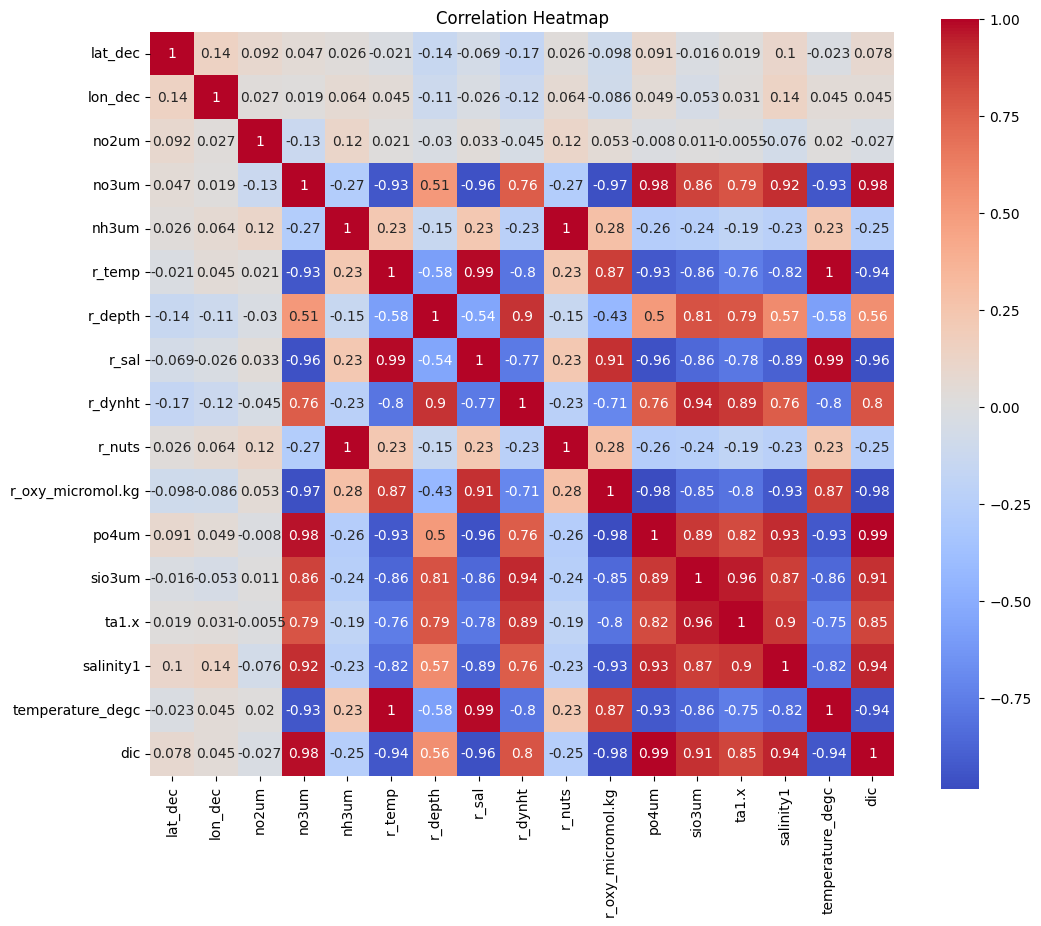

In [12]:
# heatmap of correlation between features
plt.figure(figsize=(12, 10))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# define highly correlated features to remove when creating feature matrix
columns_to_remove = ['temperature_degc', 'r_nuts']

# define feature matrix for training data
X_train = train_df.drop(['dic'] + columns_to_remove, axis=1)

# define target vector for training data
y_train = train_df['dic'].values


## Build & train model

In [25]:
# initialize new HyperModel object
class MyHyperModel:
    
    def build(self, hp):
        model = Sequential()
        
        # add dense layer with ReLU (based on preliminary training results)
        model.add(Dense(units=hp['neurons_0'], # tune units (number of neurons)
                        activation='relu', # select ReLU activator (based on preliminary training results)
                        kernel_regularizer=l1_l2(l1=0.01, l2=0.01))) # set L1 and L2
        
        # add dense layer with ELU activator (based on preliminary training results)
        model.add(Dense(units=hp['neurons_0'], # tune units (number of neurons)
                        activation='elu', # select ELU activator (based on preliminary training results)
                        kernel_regularizer=l1_l2(l1=0.01, l2=0.01))) # set L1 and L2
        
        # add dropout layer
        model.add(Dropout(rate=hp['dropout_1'])) # tune dropout rate

        # add additional dense layer(s)
        for i in range(1, hp['num_layers']):
            model.add(Dense(units=hp['neurons_0'], # tune units (number of neurons)
                            activation=hp['activation'], # tune activation function
                            kernel_regularizer=l1_l2(l1=0.01, l2=0.01))) # set L1 and L2
        
        # add output layer with linear activation
        model.add(Dense(1, activation='linear', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
        
        # configure tuning for optimizer
        optimizer = Adam(learning_rate=hp['learning_rate'], beta_1=hp['beta_1'])
        
        # compile hypermodel and set MSE as loss function
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        
        return model
    
# store HyperModel object with specified input shape based on number of columns in feature matrix
hypermodel = MyHyperModel()

In [26]:
# create hyperparameter grid for tuning
hyperparameter_grid = {
    'neurons_0': [128],
    'dropout_1': [0.0],
    'num_layers': [2],
    'activation': ['elu'],
    'learning_rate': [1e-3],
    'beta_1': [0.8]
}

# define function that creates all combinations of values stored in a dictionary
def generate_combinations(grid):
    keys, values = zip(*grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    return combinations

# store all combinations of hyperparameter values from grid
combinations = generate_combinations(hyperparameter_grid)

In [27]:
# create EarlyStopping object to use when tuning hypermodel
early_stopping = EarlyStopping(
    monitor='loss', # monitor loss function
    min_delta=0.1, # set minimum decrease in loss function to be read as improvement
    patience=10, # stop trial early if no improvement over 10 iterations
    verbose=0, # disable verbose
    mode='min', # specify that objective is to minimize function being monitored
    restore_best_weights=True) # after early stopping, revert model weights to those from the epoch with the best value of the monitored metric

# define custom function for performing a CV trial
def cross_validate_combination(X, y, combination):
    kf = KFold(n_splits=5) # initialize CV fold with 5 splits
    val_scores = [] # initialize empty vector for validation scores
    
    for train_index, val_index in kf.split(X):
        
        # build model with combination of hyperparameters
        model = hypermodel.build(combination)
        
        # build CV fold (with 10 splits) using all of training data
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        # fit model to CV fold
        model.fit(X_train_fold,
                  y_train_fold,
                  callbacks=[early_stopping], # use early stopping
                  epochs=50, # set number of epochs for each trial
                  verbose=0) # disable verbose
        
        # evaluate model performance
        val_score = model.evaluate(X_val_fold,
                                   y_val_fold,
                                   verbose=0)
        val_scores.append(val_score)
    
    # return average validation score across all 10 splits of CV fold
    return np.mean(val_scores)

# initialize objects for storing best CV score and best hyperparameter combination
best_score = float('inf')
best_combination = None

In [28]:
# determine best hyperparameter combination based on CV score
for combination in combinations:
    score = cross_validate_combination(X_train,
                                       y_train,
                                       combination)
    if score < best_score:
        best_score = score
        best_combination = combination
print("Best Hyperparameters:", best_combination)
print("Best Score:", best_score)

Best Hyperparameters: {'neurons_0': 128, 'dropout_1': 0.0, 'num_layers': 2, 'activation': 'elu', 'learning_rate': 0.001, 'beta_1': 0.8}
Best Score: 150.6020065307617


In [29]:
# create EarlyStopping object to use when finalizing fit
early_stopping_final = EarlyStopping(
    monitor='loss', # monitor loss function
    min_delta=0.1, # set minimum decrease in loss function to be read as improvement
    patience=100, # stop trial early if no improvement over 100 iterations
    verbose=1, # enable verbose
    mode='min', # specify that objective is to minimize function being monitored
    restore_best_weights=True) # after early stopping, revert model weights to those from the epoch with the best value of the monitored metric

# build version of hypermodel with best combination of hyperparameters
best_model = hypermodel.build(best_combination)

# fit model to training data
best_model.fit(X_train,
               y_train,
               callbacks=[early_stopping_final],
               epochs=500,
               verbose=0)

Restoring model weights from the end of the best epoch: 37.
Epoch 137: early stopping


In [30]:
loss = best_model.evaluate(X_train, y_train, verbose=0)
print(f"Total loss (MSE for all training data): {loss}")

Total loss (MSE for all training data): 90.12106323242188


## Import & process testing data

In [32]:
# import testing data
test_df = pd.read_csv('data/test.csv')
test_df.columns = test_df.columns.str.lower().str.replace(' ', '_') # clean column names

# remove 'id' and 'unnamed:_12' columns
test_df = test_df.drop(test_df.columns[[0]], axis=1)

# define feature matrix for testing data
X_test = test_df


## Predict DIC for testing data & export submission

In [34]:
# generate predictions for testing data
predictions = best_model.predict(X_test)

# import submission template
submission_df = pd.read_csv('data/sample_submission.csv')
submission_df.columns = submission_df.columns.str.lower().str.replace(' ', '_')

# bind predictions to 'dic' column
submission_df['dic'] = predictions

16/16 [==============================] - 0s 2ms/step


In [12]:
# export submission
# submission_df.to_csv('submission.csv', index=False)

## Conclusion
Deep learning does not seem to have been the best choice for this specific problem, at least given my time and computer power constraints. It is interesting to me how deep learning techniques represent the most innovative machine learning approach at this moment, yet they still certainly seem to have their limits when it comes to certain problems. While the neural network architecture works really well when it comes to building models where the features are visual images or text/sentiment, building an effective deep learning model with these features proved to be difficult.